In [58]:
import operator
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import gridspec
from matplotlib import pyplot as plt
from astropy import units as u
from astropy.table import QTable
from astropy.coordinates import angular_separation
from magicctapipe.utils import (
    check_tel_combination,
    get_dl2_mean,
)
from pyirf.cuts import (
    calculate_percentile_cut,
    evaluate_binned_cut,
)
from pyirf.irf import effective_area_per_energy
from pyirf.simulations import SimulatedEventsInfo
from ctaplot.ana import (
    logbin_mean,
    energy_bias,
    energy_resolution_per_energy,
    angular_resolution_per_energy,
)

In [2]:
# Display all columns:
pd.set_option('display.max_columns', None)

# Configure the default pyplot figure:
plt.rcParams.update({
    'figure.figsize': (12, 9),
    'font.size': 15,
    'grid.linestyle': 'dotted',
})

In [3]:
def calc_reldiff_err(x, y, xerr, yerr):
    """
    Calculates the error of relative differences, i.e., the error of f = (x - y) / y
    """
    
    return np.sqrt((xerr/y) ** 2 + (x*yerr/(y**2)) ** 2)

# Load MAGIC DL2 test MC

### Load an input file and apply quality cuts:

In [4]:
# === Settings ===
path_magic = '/fefs/aswg/workspace/yoshiki.ohtani/analysis/combined_analysis/mc/zd40deg_az90deg/4.dl1_to_dl2/' \
             'data_magic/gamma_off0.4deg/dl2/merged/dl2_gamma_40deg_90deg_LST-1_MAGIC_run401_to_1000.h5'

quality_cuts = 'intensity_width_2 < 0.2'

# === Main ===
print('Loading the following file:')
print(Path(path_magic).name)

data_magic = pd.read_hdf(data_path, 'events/params')
data_magic.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
data_magic.sort_index(inplace=True)

check_tel_combination(data_magic)

print('Applying the quality cuts:')
print(quality_cuts)

data_magic.query(quality_cuts, inplace=True)
data_magic['multiplicity'] = data_magic.groupby(['obs_id', 'event_id']).size()
data_magic.query('multiplicity > 1', inplace=True)

combo_types = check_tel_combination(data_magic)
data_magic = data_magic.join(combo_types)

Loading the following file:
dl2_gamma_40deg_90deg_LST-1_MAGIC_run401_to_1000.h5



In total 542907 stereo events are found:
m1_m2 (type 0): 542907 events (100.0%)
lst1_m1 (type 1): 0 events (0.0%)
lst1_m2 (type 2): 0 events (0.0%)
lst1_m1_m2 (type 3): 0 events (0.0%)


Applying the quality cuts:
intensity_width_2 < 0.2



In total 483551 stereo events are found:
m1_m2 (type 0): 483551 events (100.0%)
lst1_m1 (type 1): 0 events (0.0%)
lst1_m2 (type 2): 0 events (0.0%)
lst1_m1_m2 (type 3): 0 events (0.0%)


In [5]:
data_magic.head()

alt_tel    az_tel  mc_energy  mc_alt      mc_az  \
obs_id event_id tel_id                                                     
401    13603    2       0.865683  1.570796   0.623625    50.0  89.999996   
                3       0.865683  1.570796   0.623625    50.0  89.999996   
       13605    2       0.865683  1.570796   0.623625    50.0  89.999996   
                3       0.865683  1.570796   0.623625    50.0  89.999996   
       13606    2       0.865683  1.570796   0.623625    50.0  89.999996   

                         mc_disp   mc_core_x   mc_core_y   mc_impact  \
obs_id event_id tel_id                                                 
401    13603    2       0.271559  -13.296012  -13.278467   53.781362   
                3       0.143503  -13.296012  -13.278467   31.802946   
       13605    2       0.871795 -153.317642 -135.251175  209.426836   
                3       0.697496 -153.317642 -135.251175  171.002237   
       13606    2       0.467384  -43.840717    8.326108   87.658801   

                        n_pixels  n_islands   intensity  skewness  kurtosis  \
obs_id event_id tel_id                                                        
401    13603    2             25          1  361.691213 -0.105109  3.240736   
                3             25          1  343.057076 -0.168967  2.609355   
       13605    2             15          1  152.075211 -0.146876  2.127085   
                3             30          1  529.603398 -0.896360  3.308850   
       13606    2             29          1  396.464334  0.440234  2.266879   

                               x         y         r        phi    length  \
obs_id event_id tel_id                                                      
401    13603    2       0.146110  0.075534  0.164480  27.337523  0.038841   
                3       0.086487 -0.027991  0.090904 -17.933980  0.035061   
       13605    2       0.028732  0.242115  0.243814  83.232348  0.039845   
                3      -0.017304  0.155700  0.156658  96.341632  0.059166   
       13606    2       0.169033  0.128870  0.212556  37.321774  0.045105   

                        length_uncertainty     width  width_uncertainty  \
obs_id event_id tel_id                                                    
401    13603    2                 0.001529  0.027924           0.001028   
                3                 0.001201  0.028015           0.000971   
       13605    2                 0.001715  0.018385           0.000774   
                3                 0.001953  0.019397           0.000655   
       13606    2                 0.001275  0.029396           0.001170   

                              psi  intercept  deviation      slope  \
obs_id event_id tel_id                                               
401    13603    2        2.986770   9.102135   0.549673  -0.704183   
                3       22.777923  10.210404   0.964179  15.627531   
       13605    2      -58.240280   8.804272   0.470323  -5.870538   
                3      -49.603113   9.473720   0.755000   0.110890   
       13606    2       45.085276   9.680475   0.688451 -10.537660   

                        pixels_width_1  pixels_width_2  intensity_width_1  \
obs_id event_id tel_id                                                      
401    13603    2                  0.0             0.0                0.0   
                3                  0.0             0.0                0.0   
       13605    2                  0.0             0.0                0.0   
                3                  0.0             0.0                0.0   
       13606    2                  0.0             0.0                0.0   

                        intensity_width_2  multiplicity  event_type  \
obs_id event_id tel_id                                                
401    13603    2                     0.0             2         0.0   
                3                     0.0             2         0.0   
       13605    2                     0.0           

### Compute the mean of the DL2 parameters:

In [6]:
print('Computing the mean of the DL2 parameters...')
dl2_magic = get_dl2_mean(data_magic)

theta = angular_separation(
    lon1=u.Quantity(dl2_magic['mc_az'].to_numpy(), u.deg),
    lat1=u.Quantity(dl2_magic['mc_alt'].to_numpy(), u.deg),
    lon2=u.Quantity(dl2_magic['reco_az'].to_numpy(), u.deg),
    lat2=u.Quantity(dl2_magic['reco_alt'].to_numpy(), u.deg),
)

dl2_magic['theta2'] = theta.to(u.deg).value ** 2

Computing the mean of the DL2 parameters...
--> Number of events: 483551


In [7]:
dl2_magic.head()

combo_type  gammaness  reco_energy   reco_alt    reco_az  \
obs_id event_id                                                             
401    13603            0.0   0.920119     0.504931  50.271352  90.200619   
       13605            0.0   0.910500     0.323265  50.041818  90.195792   
       13606            0.0   0.941167     0.486283  49.819992  90.169525   
       13609            0.0   0.995000     0.598616  49.977630  90.058838   
       15600            0.0   0.958417     0.210772  49.983228  90.112785   

                  alt_tel    az_tel  mc_energy  mc_alt      mc_az    theta2  
obs_id event_id                                                              
401    13603     0.865683  1.570796   0.623625    50.0  89.999996  0.090168  
       13605     0.865683  1.570796   0.623625    50.0  89.999996  0.017575  
       13606     0.865683  1.570796   0.623625    50.0  89.999996  0.044322  
       13609     0.865683  1.570796   0.623625    50.0  89.999996  0.001932  
       15600     0.865683  1.570796   0.216644    50.0  89.999996  0.005539

# Load LST-1 + MAGIC DL2 test MC

### Load an input file and apply quality cuts:

In [31]:
# === Settings ===
path_mlst = '/fefs/aswg/workspace/yoshiki.ohtani/analysis/combined_analysis/mc/zd40deg_az90deg/4.dl1_to_dl2/' \
            'data/gamma_off0.4deg/dl2/merged/dl2_gamma_40deg_90deg_LST-1_MAGIC_run401_to_1000.h5'

quality_cuts = 'intensity_width_2 < 0.2'

# === Main ===
print('Loading the following file:')
print(Path(path_mlst).name)

data_mlst = pd.read_hdf(data_path, 'events/params')
data_mlst.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
data_mlst.sort_index(inplace=True)

check_tel_combination(data_mlst)

print('Applying the quality cuts:')
print(quality_cuts)

data_mlst.query(quality_cuts, inplace=True)
data_mlst['multiplicity'] = data_mlst.groupby(['obs_id', 'event_id']).size()
data_mlst.query('multiplicity > 1', inplace=True)

combo_types = check_tel_combination(data_mlst)
data_mlst = data_mlst.join(combo_types)

Loading the following file:
dl2_gamma_40deg_90deg_LST-1_MAGIC_run401_to_1000.h5



In total 967658 stereo events are found:
m1_m2 (type 0): 2317 events (0.2%)
lst1_m1 (type 1): 154371 events (16.0%)
lst1_m2 (type 2): 270380 events (27.9%)
lst1_m1_m2 (type 3): 540590 events (55.9%)


Applying the quality cuts:
intensity_width_2 < 0.2



In total 886733 stereo events are found:
m1_m2 (type 0): 2410 events (0.3%)
lst1_m1 (type 1): 146764 events (16.6%)
lst1_m2 (type 2): 256418 events (28.9%)
lst1_m1_m2 (type 3): 481141 events (54.3%)


In [9]:
data_mlst.head()

alt_tel    az_tel  mc_energy  mc_alt      mc_az  \
obs_id event_id tel_id                                                     
401    801      1       0.865683  1.570796   0.140737    50.0  89.999996   
                2       0.865683  1.570796   0.140737    50.0  89.999996   
       3600     1       0.865683  1.570796   0.144728    50.0  89.999996   
                3       0.865683  1.570796   0.144728    50.0  89.999996   
       8903     1       0.865683  1.570796   0.077887    50.0  89.999996   

                         mc_disp   mc_core_x  mc_core_y   mc_impact  n_pixels  \
obs_id event_id tel_id                                                          
401    801      1       0.374802  -66.894005   77.39901   64.888548        24   
                2       0.527436  -66.894005   77.39901  133.373130        13   
       3600     1       0.436718  -80.773026  162.18277   81.793319        22   
                3       0.552227  -80.773026  162.18277  118.950961        11   
       8903     1       0.767275 -121.733177  110.57663  113.661095        16   

                        n_islands   intensity  skewness  kurtosis         x  \
obs_id event_id tel_id                                                        
401    801      1               1  334.670504 -0.343692  2.307648  0.121195   
                2               1   83.743346  0.396146  2.287309  0.217718   
       3600     1               1  269.086090  0.645116  2.835470  0.316577   
                3               1   94.909568  0.014846  1.997308  0.269874   
       8903     1               1  240.214608  0.143741  2.061847  0.200230   

                               y         r        phi    length  \
obs_id event_id tel_id                                            
401    801      1       0.167424  0.206686  54.100067  0.085359   
                2       0.120645  0.248911  28.992405  0.037036   
       3600     1       0.175741  0.362086  29.035908  0.063218   
                3       0.061885  0.276879  12.915208  0.038042   
       8903     1       0.374938  0.425054  61.896299  0.072251   

                        length_uncertainty     width  width_uncertainty  \
obs_id event_id tel_id                                                    
401    801      1                 0.002668  0.044844           0.001649   
                2                 0.002296  0.021452           0.001307   
       3600     1                 0.002611  0.046211           0.002021   
                3                 0.001950  0.014437           0.000779   
       8903     1                 0.002402  0.026708           0.001271   

                              psi  intercept  deviation     slope  \
obs_id event_id tel_id                                              
401    801      1      -56.989771  13.292052   0.862620  6.932786   
                2       47.624256   8.536034   0.234822 -0.716290   
       3600     1       39.494697  12.687470   2.930561 -3.272539   
                3       10.113007   7.953780   0.627594 -7.782651   
       8903     1       88.689926  11.849434   0.530673 -3.735744   

                        pixels_width_1  pixels_width_2  intensity_width_1  \
obs_id event_id tel_id                                                      
401    801      1                  0.0             0.0                0.0   
                2                  0.0             0.0                0.0   
       3600     1                  0.0             0.0                0.0   
                3                  0.0             0.0                0.0   
       8903     1                  0.0             0.0                0.0   

                        intensity_width_2  multiplicity  event_type  \
obs_id event_id tel_id                                                
401    801      1                     0.0             2         1.0   
                2                     0.0             2         1.0   
       3600     1                     0.0             2         2.

### Compute the mean of the DL2 parameters:

In [10]:
print('Computing the mean of the DL2 parameters...')
dl2_mlst = get_dl2_mean(data_mlst)

theta = angular_separation(
    lon1=u.Quantity(dl2_mlst['mc_az'].to_numpy(), u.deg),
    lat1=u.Quantity(dl2_mlst['mc_alt'].to_numpy(), u.deg),
    lon2=u.Quantity(dl2_mlst['reco_az'].to_numpy(), u.deg),
    lat2=u.Quantity(dl2_mlst['reco_alt'].to_numpy(), u.deg),
)

dl2_mlst['theta2'] = theta.to(u.deg).value ** 2

print('\nExtracting only 3-tels events...')
dl2_mlst.query('combo_type == 3', inplace=True)

print(f'--> Number of events: {len(dl2_mlst)}')

Computing the mean of the DL2 parameters...
Extracting only 3-tels events...
--> Number of events: 481141


In [11]:
dl2_mlst.head()

combo_type  gammaness  reco_energy   reco_alt    reco_az  \
obs_id event_id                                                             
401    13603            3.0   0.980222     0.462640  50.234875  90.165232   
       13605            3.0   0.985389     0.444506  49.992795  90.133537   
       13606            3.0   0.914667     0.527422  49.942015  90.094255   
       13609            3.0   0.966389     0.595852  49.959822  90.022747   
       15600            3.0   0.962028     0.225596  49.972739  90.070327   

                  alt_tel    az_tel  mc_energy  mc_alt      mc_az    theta2  
obs_id event_id                                                              
401    13603     0.865683  1.570796   0.623625    50.0  89.999996  0.066392  
       13605     0.865683  1.570796   0.623625    50.0  89.999996  0.007421  
       13606     0.865683  1.570796   0.623625    50.0  89.999996  0.007038  
       13609     0.865683  1.570796   0.623625    50.0  89.999996  0.001828  
       15600     0.865683  1.570796   0.216644    50.0  89.999996  0.002788

# Check the reconstructed energy

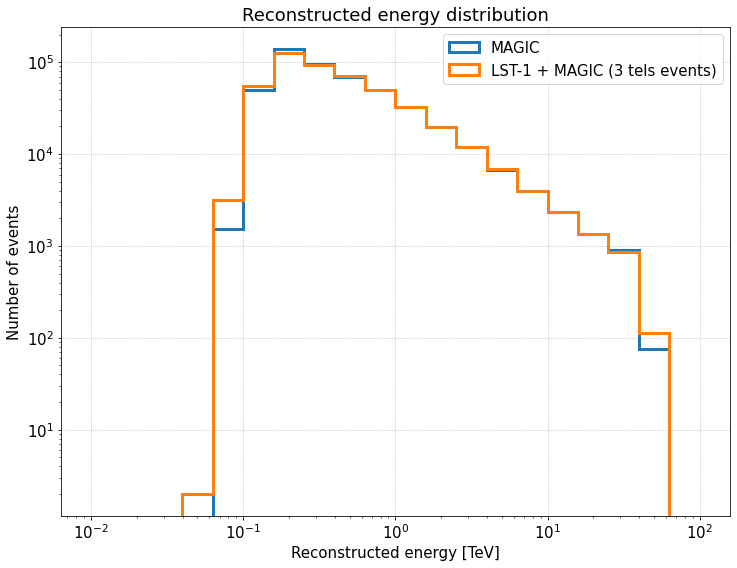

In [12]:
# === Settings ===
bins_eng = np.logspace(-2, 2, 21)

# === Main ===
plt.figure()
plt.title('Reconstructed energy distribution')
plt.xlabel('Reconstructed energy [TeV]')
plt.ylabel('Number of events')
plt.loglog()

plt.hist(
    dl2_magic['reco_energy'].to_numpy(), bins=bins_eng,
    label='MAGIC', histtype='step', linewidth=3,
)

plt.hist(
    dl2_mlst['reco_energy'].to_numpy(), bins=bins_eng,
    label='LST-1 + MAGIC (3 tels events)', histtype='step', linewidth=3,
)

plt.grid()
plt.legend()
plt.show()

# Check the gammaness

### Gammaness distribution:

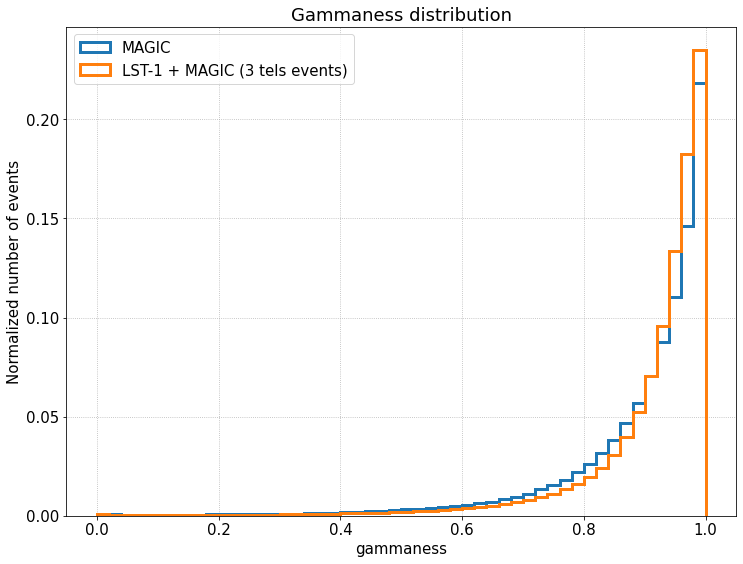

In [13]:
# === Settings ===
bins_gam = np.linspace(0, 1, 51)
yscale = 'linear'

# === Main ===
plt.figure()
plt.title('Gammaness distribution')
plt.xlabel('gammaness')
plt.ylabel('Normalized number of events')
plt.yscale(yscale)

plt.hist(
    dl2_magic['gammaness'].to_numpy(), bins=bins_gam, 
    weights=np.repeat(1/len(dl2_magic), len(dl2_magic)),
    label='MAGIC', histtype='step', linewidth=3,
)

plt.hist(
    dl2_mlst['gammaness'].to_numpy(), bins=bins_gam, 
    weights=np.repeat(1/len(dl2_mlst), len(dl2_mlst)),
    label='LST-1 + MAGIC (3 tels events)', 
    histtype='step', linewidth=3,
)

plt.grid()
plt.legend(loc='upper left')
plt.show()

### Gammaness distribution in each energy bin:

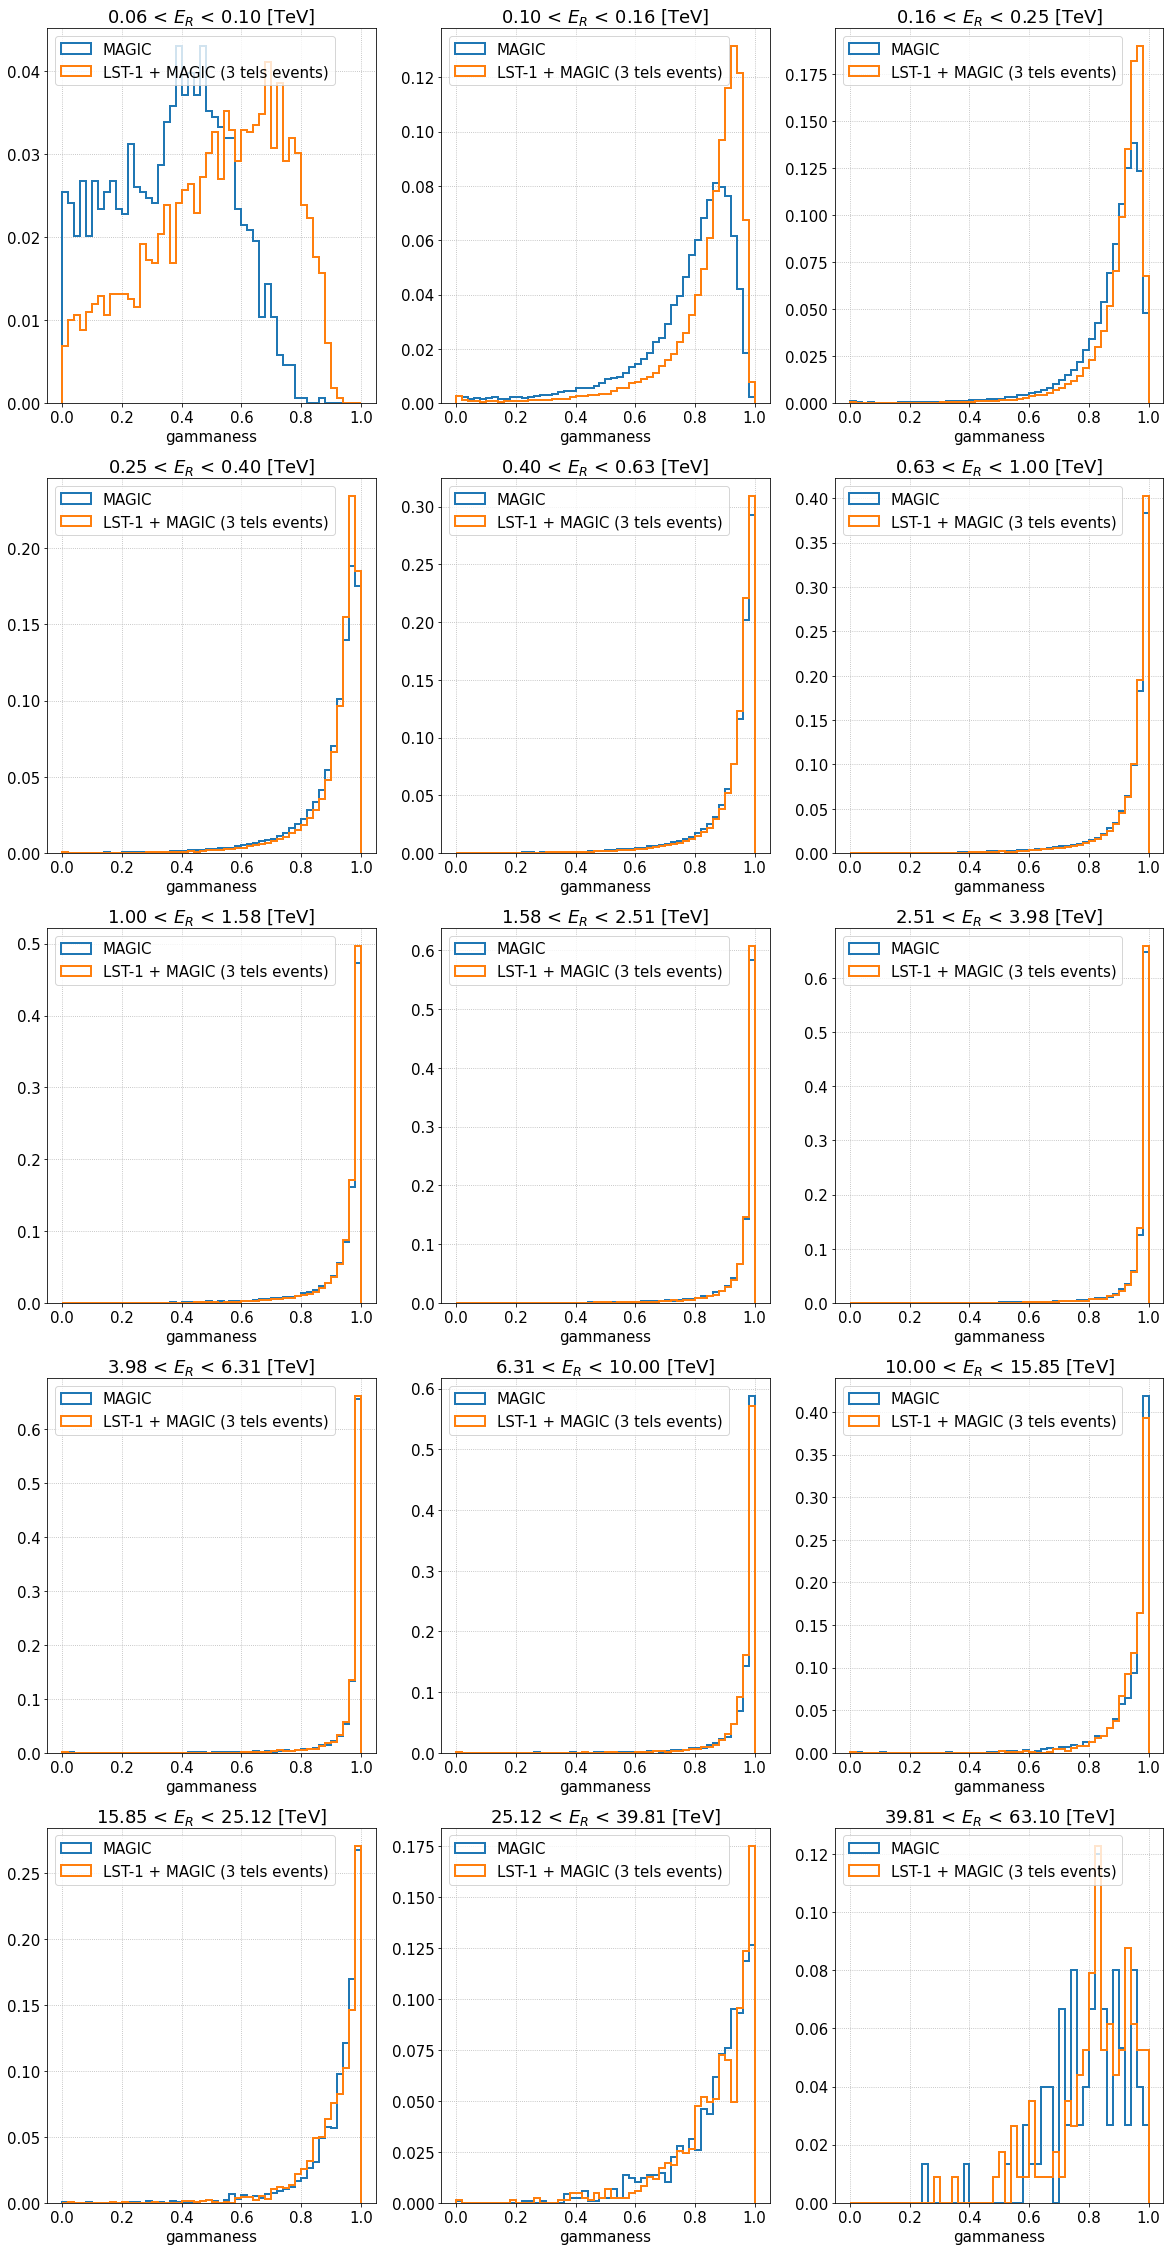

In [14]:
# === Settings ===
bins_eng = np.logspace(-2, 2, 21)[4:-1]
bins_gam = np.linspace(0, 1, 51)

figsize = (20, 40)
yscale = 'linear'

# === Main ===
plt.figure(figsize=figsize)

grid = (int(np.ceil(len(bins_eng[:-1])/3)), 3)
locs = list(itertools.product(range(grid[0]), range(grid[1])))

for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(bins_eng[:-1], bins_eng[1:])):
    
    event_cuts = f'(reco_energy > {eng_lolim}) & (reco_energy < {eng_uplim})'
    
    df_magic = dl2_magic.query(event_cuts)
    df_mlst = dl2_mlst.query(event_cuts)
    
    plt.subplot2grid(grid, locs[i_bin])
    plt.title(rf'{eng_lolim:.2f} < $E_R$ < {eng_uplim:.2f} [TeV]')
    plt.xlabel('gammaness')
    plt.yscale(yscale)

    if len(df_magic) > 0:
        plt.hist(
            df_magic['gammaness'].to_numpy(), bins=bins_gam,
            weights=np.repeat(1/len(df_magic), len(df_magic)),
            label='MAGIC', histtype='step', linewidth=2,
        )

    if len(df_mlst) > 0:
        plt.hist(
            df_mlst['gammaness'].to_numpy(), bins=bins_gam,
            weights=np.repeat(1/len(df_mlst), len(df_mlst)),
            label='LST-1 + MAGIC (3 tels events)', 
            histtype='step', linewidth=2,
        )

    plt.grid()
    plt.legend(loc='upper left')
    
plt.show()

### Gammaness cuts based on the gamma efficiency:

In [15]:
# === Settings ===
gamma_eff = 0.95
bins_eng = np.logspace(-2, 2, 21)

# === Main ===
percentile = 100 * (1 - gamma_eff)

cut_table_magic = calculate_percentile_cut(
    values=dl2_magic['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_magic['reco_energy'].to_numpy(), u.TeV),
    bins=u.Quantity(bins_eng, u.TeV),
    fill_value=1.0,
    percentile=percentile,
)

cut_table_mlst = calculate_percentile_cut(
    values=dl2_mlst['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_mlst['reco_energy'].to_numpy(), u.TeV),
    bins=u.Quantity(bins_eng, u.TeV),
    fill_value=1.0,
    percentile=percentile,
)

In [16]:
cut_table_mlst

low,high,center,cut
TeV,TeV,TeV,
float64,float64,float64,float64
0.01,0.015848931924611134,0.012924465962305568,1.0
0.015848931924611134,0.025118864315095794,0.020483898119853464,1.0
0.025118864315095794,0.039810717055349734,0.03246479068522276,1.0
0.039810717055349734,0.06309573444801933,0.05145322575168453,1.0
0.06309573444801933,0.1,0.08154786722400967,0.10474920634920643
0.1,0.15848931924611143,0.1292446596230557,0.5560069444444447
0.15848931924611143,0.25118864315095807,0.20483898119853475,0.7049728174603174
0.25118864315095807,0.3981071705534973,0.32464790685222766,0.6902329365079368


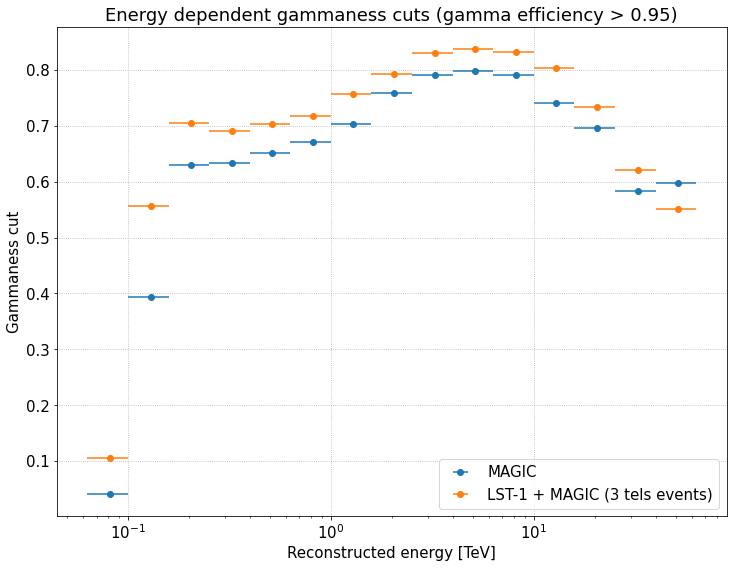

In [17]:
plt.figure()
plt.title(f'Energy dependent gammaness cuts (gamma efficiency > {gamma_eff})')
plt.xlabel('Reconstructed energy [TeV]')
plt.ylabel('Gammaness cut')
plt.semilogx()

# Mask the cut = 1:
mask = (cut_table_magic['cut'] < 1)

plt.errorbar(
    x=cut_table_magic['center'].value[mask], y=cut_table_magic['cut'].value[mask],
    xerr=[(cut_table_magic['center'] - cut_table_magic['low']).value[mask],
          (cut_table_magic['high'] - cut_table_magic['center']).value[mask]],
    label='MAGIC', fmt='o',
)

plt.errorbar(
    x=cut_table_mlst['center'].value[mask], y=cut_table_mlst['cut'].value[mask],
    xerr=[(cut_table_mlst['center'] - cut_table_mlst['low']).value[mask],
          (cut_table_mlst['high'] - cut_table_mlst['center']).value[mask]],
    label='LST-1 + MAGIC (3 tels events)', fmt='o',
)

plt.grid()
plt.legend(loc='lower right')
plt.show()

In [18]:
mask_gh_magic = evaluate_binned_cut(
    values=dl2_magic['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_magic['reco_energy'].to_numpy(), u.TeV),
    cut_table=cut_table_magic,
    op=operator.ge,
)

n_events_magic = np.count_nonzero(mask_gh_magic)
print(f'Number of survived MAGIC events: {n_events_magic}')

mask_gh_mlst = evaluate_binned_cut(
    values=dl2_mlst['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_mlst['reco_energy'].to_numpy(), u.TeV),
    cut_table=cut_table_mlst,
    op=operator.ge,
)

n_events = np.count_nonzero(mask_gh_mlst)
print(f'Number of survived LST-1 + MAGIC events: {n_events}')

Number of survived MAGIC events: 459367
Number of survived LST-1 + MAGIC events: 457073


# Check the effective area

In [46]:
# Get the number of simulation runs:
n_runs = len(np.unique(dl2_mlst.index.get_level_values('obs_id')))

# Set the simulation info:
sim_config = pd.read_hdf(path_mlst, 'simulation/config')
n_total_showers = n_runs * sim_config['num_showers'].iloc[0] * sim_config['shower_reuse'].iloc[0]

sim_info = SimulatedEventsInfo(
    n_showers=n_total_showers,
    energy_min=u.Quantity(sim_config['energy_range_min'].iloc[0], u.TeV),
    energy_max=u.Quantity(sim_config['energy_range_max'].iloc[0], u.TeV),
    max_impact=u.Quantity(sim_config['max_scatter_range'].iloc[0], u.m),
    spectral_index=sim_config['spectral_index'].iloc[0],
    viewcone=u.Quantity(sim_config['max_viewcone_radius'].iloc[0], u.deg),
)

In [47]:
sim_info

SimulatedEventsInfo(n_showers=120000000, energy_min=0.005 TeV, energy_max=50.00 TeV, spectral_index=-2.0, max_impact=600.00 m, viewcone=0.0 deg)

In [67]:
# === Settings ===
bins_eng = np.logspace(-2, 2, 21)[2:-1]

# === Main ===
qtable_magic = QTable({'true_energy': dl2_magic['mc_energy'][mask_gh_magic].to_numpy()})
qtable_magic['true_energy'] *= u.TeV

aeff_magic = effective_area_per_energy(
    selected_events=qtable_magic,
    simulation_info=sim_info,
    true_energy_bins=u.Quantity(bins_eng, u.TeV),
)

qtable_mlst = QTable({'true_energy': dl2_mlst['mc_energy'][mask_gh_mlst].to_numpy()})
qtable_mlst['true_energy'] *= u.TeV

aeff_mlst = effective_area_per_energy(
    selected_events=qtable_mlst,
    simulation_info=sim_info,
    true_energy_bins=u.Quantity(bins_eng, u.TeV),
)

In [68]:
aeff_mlst

<Quantity [4.23345623e+00, 2.27312301e+02, 4.07184044e+03, 2.88856974e+04,
           7.72418035e+04, 1.14411079e+05, 1.44408374e+05, 1.65274315e+05,
           1.70028225e+05, 1.58705612e+05, 1.49954151e+05, 1.39559180e+05,
           1.23160606e+05, 1.16392624e+05, 1.04093138e+05, 9.69846337e+04,
           7.62174525e+04] m2>

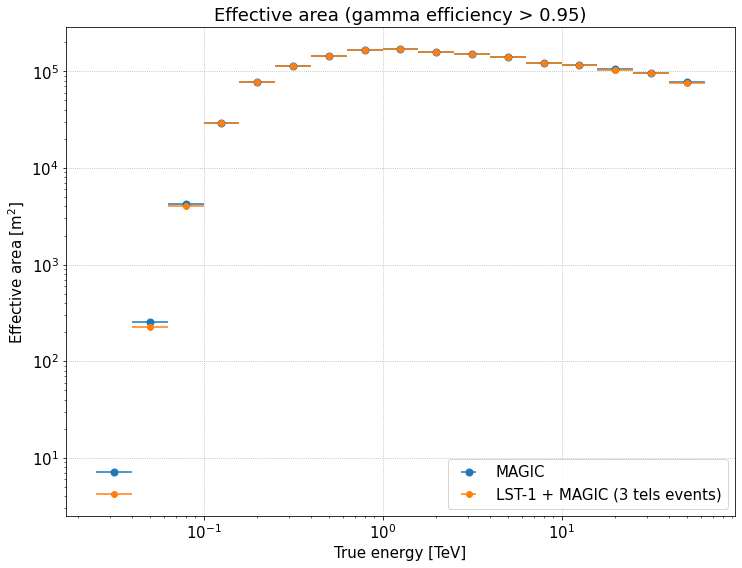

In [74]:
ebins_mean = logbin_mean(bins_eng)
ebins_lo = bins_eng[:-1]
ebins_hi = bins_eng[1:]

plt.figure()
plt.title(f'Effective area (gamma efficiency > {gamma_eff})')
plt.xlabel('True energy [TeV]')
plt.ylabel('Effective area [m$^2$]')
plt.loglog()

plt.errorbar(
    x=ebins_mean, y=aeff_magic.value,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    fmt='o', label='MAGIC',
)

plt.errorbar(
    x=ebins_mean, y=aeff_mlst.value,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    fmt='o', label='LST-1 + MAGIC (3 tels events)',
)

plt.grid()
plt.legend()
plt.show()

# Check the energy resolution

In [19]:
ebins, eres_magic = energy_resolution_per_energy(
    true_energy=dl2_magic['mc_energy'][mask_gh_magic].to_numpy(),
    reco_energy=dl2_magic['reco_energy'][mask_gh_magic].to_numpy(),
)


_, eres_mlst = energy_resolution_per_energy(
    true_energy=dl2_mlst['mc_energy'][mask_gh_mlst].to_numpy(),
    reco_energy=dl2_mlst['reco_energy'][mask_gh_mlst].to_numpy(),
)

# Mask the resolution = 0:
mask = (eres_magic[:, 0] > 0)

eres_magic = eres_magic[mask]
eres_mlst = eres_mlst[mask]

ebins_lo = ebins[:-1][mask]
ebins_hi = ebins[1:][mask]
ebins_mean = logbin_mean(ebins)[mask]

In [20]:
eres_mlst

array([[0.33398577, 0.32145118, 0.34336201],
       [0.25568591, 0.25371784, 0.25782479],
       [0.19691687, 0.19605723, 0.197885  ],
       [0.1665024 , 0.16563442, 0.16750835],
       [0.14278566, 0.14184244, 0.14368593],
       [0.12349308, 0.12258269, 0.1244662 ],
       [0.10425379, 0.10333266, 0.10523534],
       [0.09071768, 0.08965349, 0.09172446],
       [0.08336993, 0.08177506, 0.08463304],
       [0.07971596, 0.07825326, 0.08154878],
       [0.07728111, 0.07522876, 0.07879292],
       [0.08183468, 0.07904314, 0.0848461 ],
       [0.09464292, 0.09065968, 0.09982399],
       [0.09867229, 0.09468781, 0.10441539],
       [0.10054464, 0.08897711, 0.11736777]])

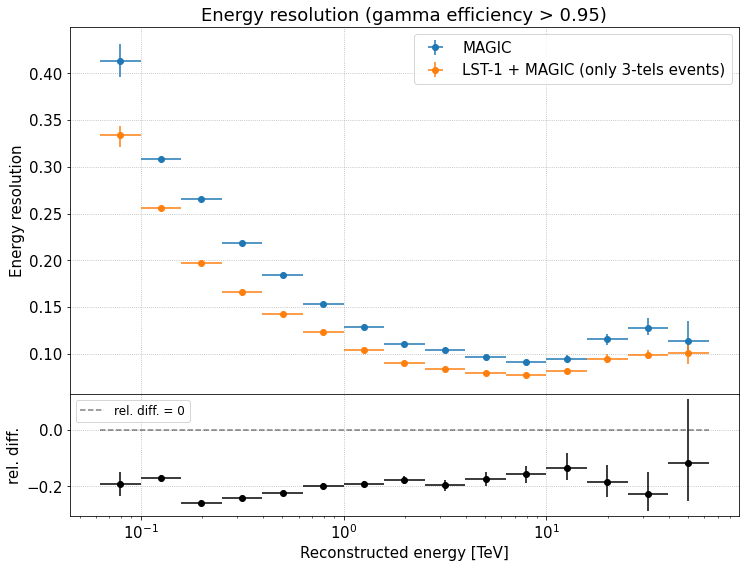

In [21]:
plt.figure()
gs = gridspec.GridSpec(4, 1)

# Plot the energy resolutions:
ax1 = plt.subplot(gs[:3])
ax1.set_title(f'Energy resolution (gamma efficiency > {gamma_eff})')
ax1.set_ylabel('Energy resolution')
ax1.semilogx()

ax1.errorbar(
    x=ebins_mean, y=eres_magic[:, 0],
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[eres_magic[:, 0] - eres_magic[:, 1], eres_magic[:, 2] - eres_magic[:, 0]],
    label='MAGIC', fmt='o', 
)

ax1.errorbar(
    x=ebins_mean, y=eres_mlst[:, 0],
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[eres_mlst[:, 0] - eres_mlst[:, 1], eres_mlst[:, 2] - eres_mlst[:, 0]],
    label='LST-1 + MAGIC (only 3-tels events)', fmt='o', 
)

ax1.legend()
ax1.grid()

plt.setp(ax1.get_xticklabels(), visible=False)

# Plot the relative difference: 
ax2 = plt.subplot(gs[3], sharex=ax1)
ax2.set_xlabel('Reconstructed energy [TeV]')
ax2.set_ylabel('rel. diff.')
ax2.semilogx()

rel_diff = (eres_mlst[:, 0] - eres_magic[:, 0]) / eres_magic[:, 0]

yerr_1 = calc_reldiff_err(
    x=eres_mlst[:, 0], y=eres_magic[:, 0], 
    xerr=eres_mlst[:, 0] - eres_mlst[:, 1], 
    yerr=eres_magic[:, 0] - eres_magic[:, 1],
)

yerr_2 = calc_reldiff_err(
    x=eres_mlst[:, 0], y=eres_magic[:, 0], 
    xerr=eres_mlst[:, 2] - eres_mlst[:, 0], 
    yerr=eres_magic[:, 2] - eres_magic[:, 0],
)

ax2.errorbar(
    x=ebins_mean, y=rel_diff,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[yerr_1, yerr_2], fmt='o', color='black',
)

ax2.plot(
    (ebins_lo[0], ebins_hi[-1]), (0, 0),
    linestyle='--', color='black', alpha=0.5, label='rel. diff. = 0',
)

ax2.grid()
ax2.legend(loc='upper left', fontsize=12)

plt.subplots_adjust(hspace=.0)
plt.show()

# Check the energy bias

In [22]:
ebins, ebias_magic = energy_bias(
    true_energy=dl2_magic['mc_energy'][mask_gh_magic].to_numpy(),
    reco_energy=dl2_magic['reco_energy'][mask_gh_magic].to_numpy(),
)

_, ebias_mlst = energy_bias(
    true_energy=dl2_mlst['mc_energy'][mask_gh_mlst].to_numpy(),
    reco_energy=dl2_mlst['reco_energy'][mask_gh_mlst].to_numpy(),
)

# Mask the bias = 0:
mask = (ebias_magic != 0)

ebias_magic = ebias_magic[mask]
ebias_mlst = ebias_mlst[mask]

ebins_lo = ebins[:-1][mask]
ebins_hi = ebins[1:][mask]
ebins_mean = logbin_mean(ebins)[mask]

In [23]:
ebias_mlst

array([ 0.15220217,  0.0879581 ,  0.00439643, -0.03556482, -0.03278522,
       -0.02832975, -0.01929783, -0.01623743, -0.01377775, -0.01257006,
       -0.00966532, -0.00937159, -0.01081885, -0.02430402, -0.06909851])

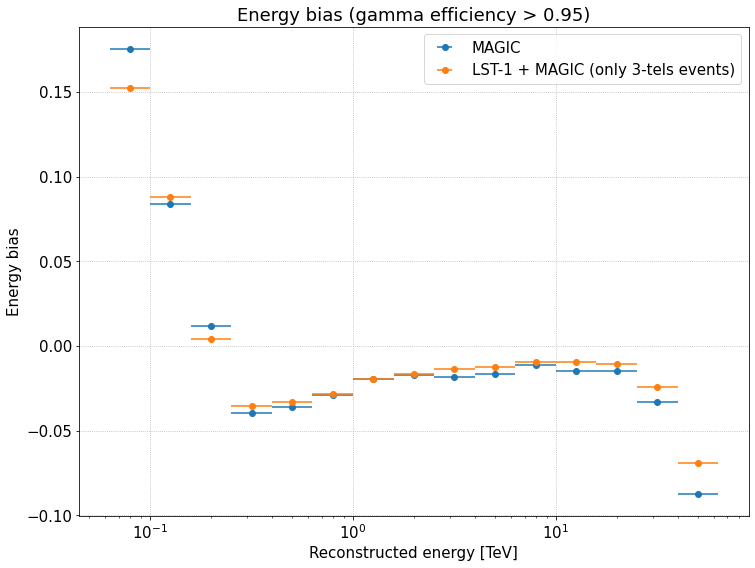

In [24]:
plt.figure()
plt.title(f'Energy bias (gamma efficiency > {gamma_eff})')
plt.xlabel('Reconstructed energy [TeV]')
plt.ylabel('Energy bias')
plt.semilogx()

plt.errorbar(
    ebins_mean, ebias_magic,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    fmt='o', label='MAGIC',
)

plt.errorbar(
    ebins_mean, ebias_mlst,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    fmt='o', label='LST-1 + MAGIC (only 3-tels events)',
)

plt.grid()
plt.legend()
plt.show()

# Check the reconstructed direction

### Theta2 distribution:

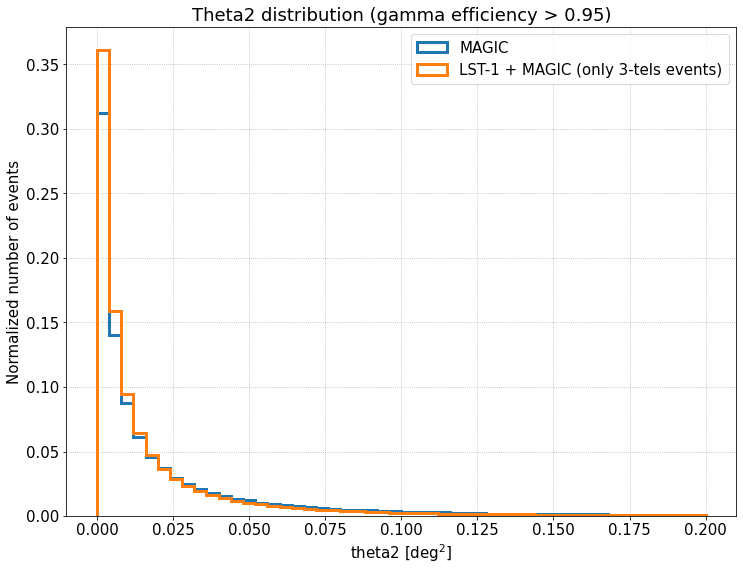

In [25]:
# === Settings ===
bins_t2 = np.linspace(0, 0.2, 51)
yscale = 'linear'

# === Main ===
plt.figure()
plt.title(f'Theta2 distribution (gamma efficiency > {gamma_eff})')
plt.xlabel('theta2 [deg$^2$]')
plt.ylabel('Normalized number of events')
plt.yscale(yscale)

plt.hist(
    dl2_magic['theta2'][mask_gh_magic].to_numpy(), bins=bins_t2, 
    weights=np.repeat(1/len(dl2_magic[mask_gh_magic]), len(dl2_magic[mask_gh_magic])),
    label='MAGIC', histtype='step', linewidth=3,
)

plt.hist(
    dl2_mlst['theta2'][mask_gh_mlst].to_numpy(), bins=bins_t2,
    weights=np.repeat(1/len(dl2_mlst[mask_gh_mlst]), len(dl2_mlst[mask_gh_mlst])),
    label='LST-1 + MAGIC (only 3-tels events)', histtype='step', linewidth=3,
)

plt.grid()
plt.legend()
plt.show()

### Theta2 distribution in each energy bin:

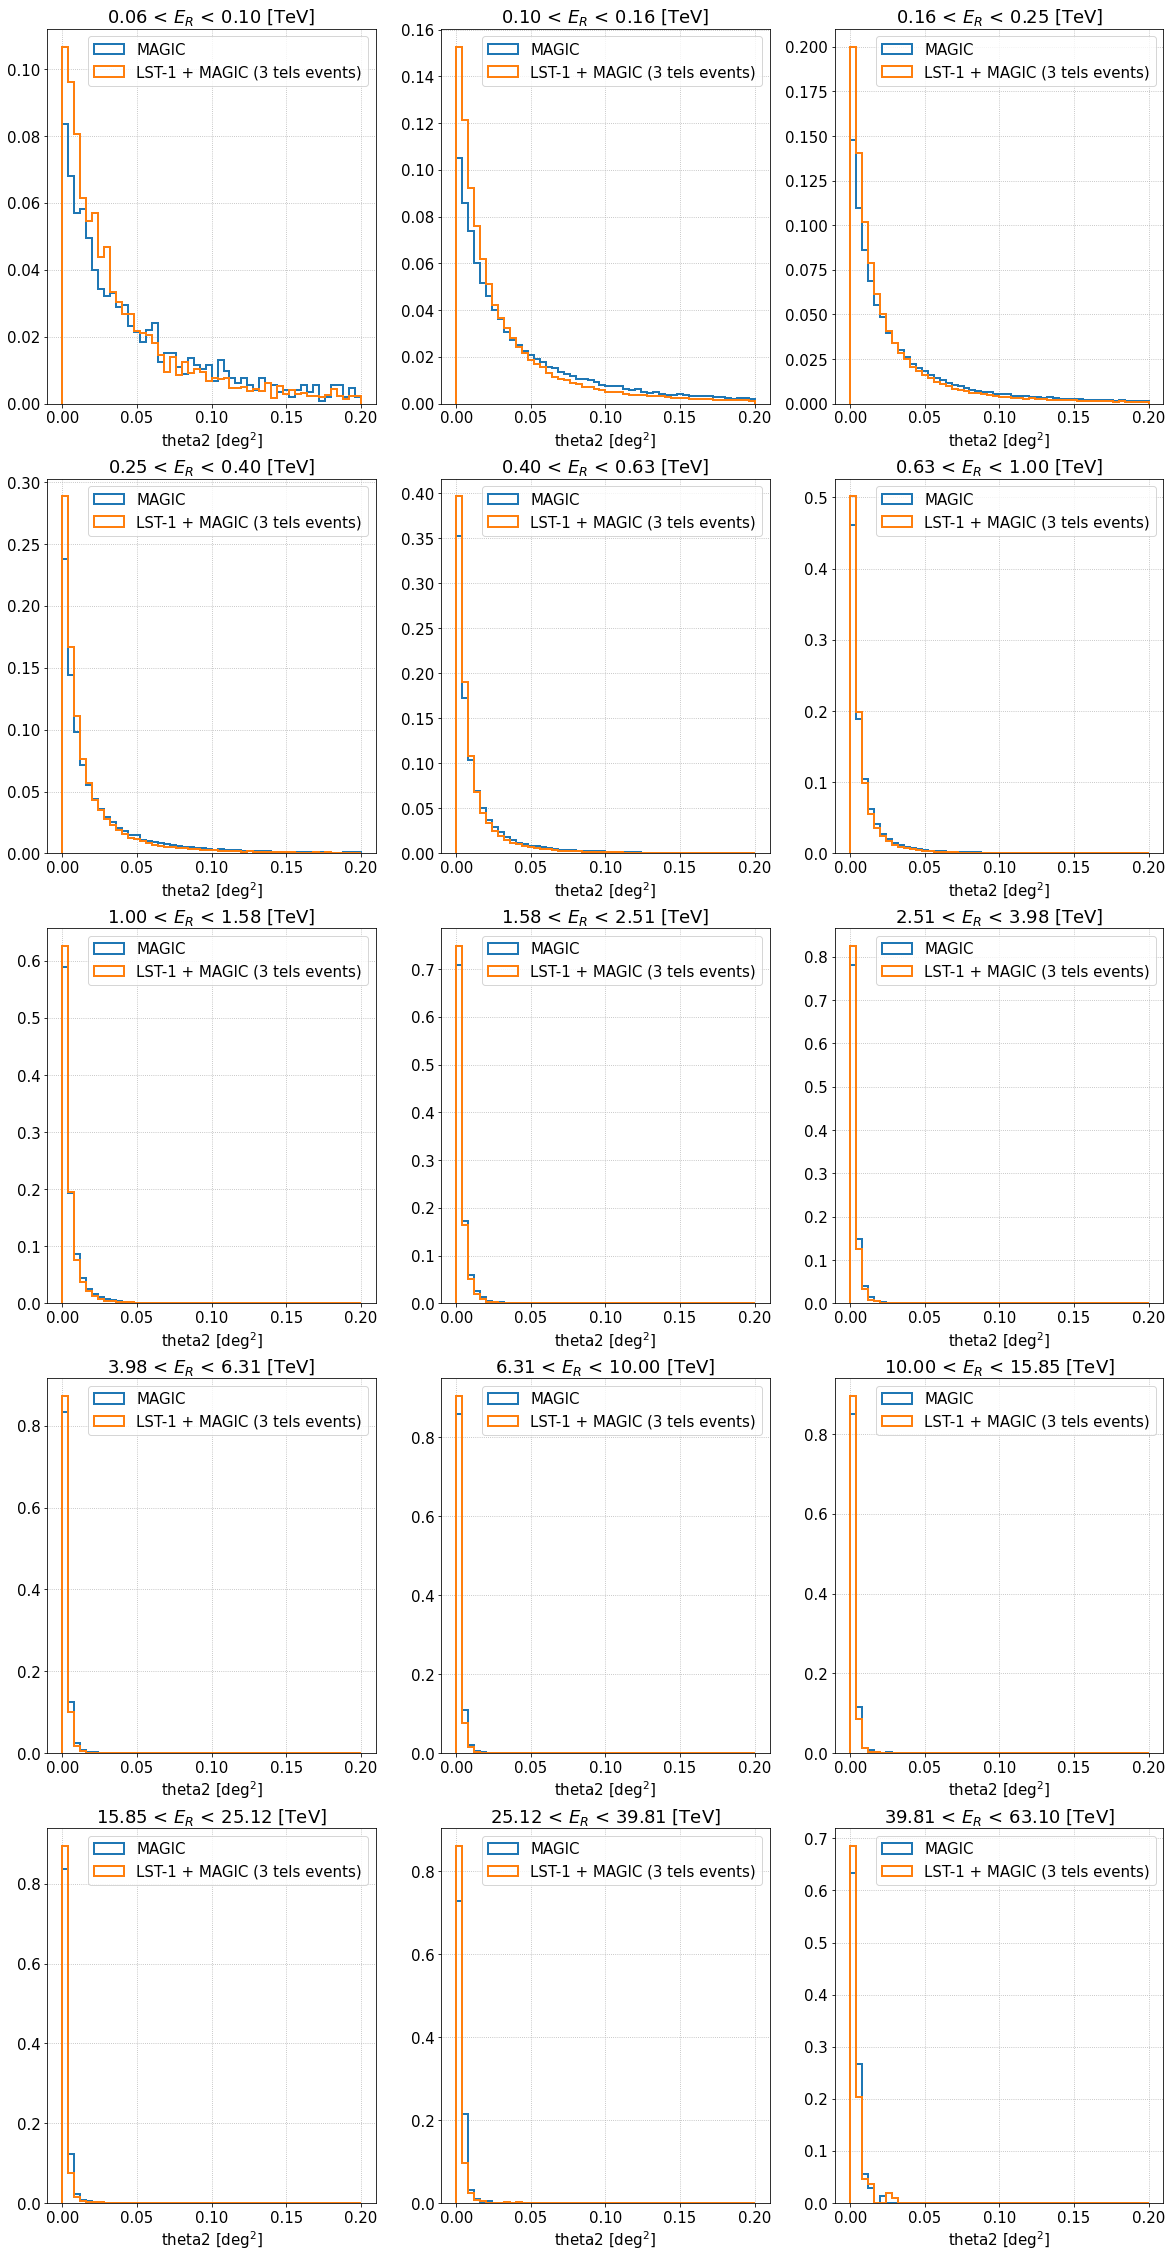

In [26]:
# === Settings ===
bins_eng = np.logspace(-2, 2, 21)[4:-1]
bins_t2 = np.linspace(0, 0.2, 51)

figsize = (20, 40)
yscale = 'linear'

# === Main ===
plt.figure(figsize=figsize)

grid = (int(np.ceil(len(bins_eng[:-1])/3)), 3)
locs = list(itertools.product(range(grid[0]), range(grid[1])))

for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(bins_eng[:-1], bins_eng[1:])):
    
    event_cuts = f'(reco_energy > {eng_lolim}) & (reco_energy < {eng_uplim})'
    
    df_magic = dl2_magic[mask_gh_magic].query(event_cuts)
    df_mlst = dl2_mlst[mask_gh_mlst].query(event_cuts)
    
    plt.subplot2grid(grid, locs[i_bin])
    plt.title(rf'{eng_lolim:.2f} < $E_R$ < {eng_uplim:.2f} [TeV]')
    plt.xlabel('theta2 [deg$^2$]')
    plt.yscale(yscale)

    if len(df_magic) > 0:
        plt.hist(
            df_magic['theta2'].to_numpy(), bins=bins_t2,
            weights=np.repeat(1/len(df_magic), len(df_magic)),
            label='MAGIC', histtype='step', linewidth=2,
        )

    if len(df_mlst) > 0:
        plt.hist(
            df_mlst['theta2'].to_numpy(), bins=bins_t2,
            weights=np.repeat(1/len(df_mlst), len(df_mlst)),
            label='LST-1 + MAGIC (3 tels events)', 
            histtype='step', linewidth=2,
        )

    plt.grid()
    plt.legend(loc='upper right')
    
plt.show()

# Check the angular resolution

In [27]:
ebins, angres_magic = angular_resolution_per_energy(
    reco_alt=dl2_magic['reco_alt'][mask_gh_magic].to_numpy(),
    reco_az=dl2_magic['reco_az'][mask_gh_magic].to_numpy(),
    true_alt=dl2_magic['mc_alt'][mask_gh_magic].to_numpy(),
    true_az=dl2_magic['mc_az'][mask_gh_magic].to_numpy(),
    energy=dl2_magic['reco_energy'][mask_gh_magic].to_numpy(),
)

_, angres_mlst = angular_resolution_per_energy(
    reco_alt=dl2_mlst['reco_alt'][mask_gh_mlst].to_numpy(),
    reco_az=dl2_mlst['reco_az'][mask_gh_mlst].to_numpy(),
    true_alt=dl2_mlst['mc_alt'][mask_gh_mlst].to_numpy(),
    true_az=dl2_mlst['mc_az'][mask_gh_mlst].to_numpy(),
    energy=dl2_mlst['reco_energy'][mask_gh_mlst].to_numpy(),
)

# Mask the resolution = 0:
mask = (angres_magic[:, 0] > 0)

angres_magic = angres_magic[mask]
angres_mlst = angres_mlst[mask]

ebins_lo = ebins[:-1][mask]
ebins_hi = ebins[1:][mask]
ebins_mean = logbin_mean(ebins)[mask]

In [28]:
angres_mlst

array([[0.28080795, 0.27202461, 0.28739474],
       [0.23803169, 0.23633397, 0.23959917],
       [0.20659333, 0.20579891, 0.20746483],
       [0.16749324, 0.1666631 , 0.16833316],
       [0.13124592, 0.13045961, 0.13204544],
       [0.10574455, 0.10511825, 0.10635128],
       [0.08431659, 0.08364428, 0.08483417],
       [0.06973551, 0.0691516 , 0.07029232],
       [0.06131033, 0.06071041, 0.06200281],
       [0.05669847, 0.05601654, 0.05749561],
       [0.05379228, 0.05302556, 0.0549578 ],
       [0.05527422, 0.05394622, 0.056646  ],
       [0.05468629, 0.05341051, 0.05657561],
       [0.05935912, 0.05786173, 0.06138729],
       [0.07720863, 0.06523299, 0.08982466]])

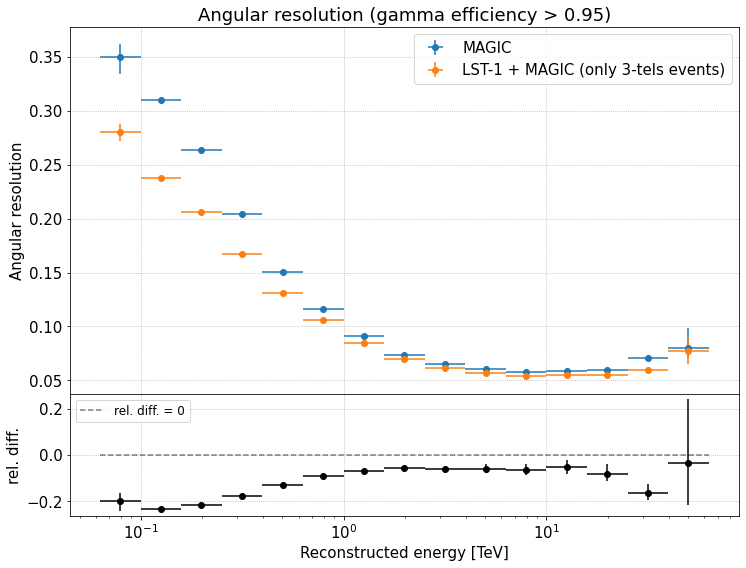

In [29]:
plt.figure()
gs = gridspec.GridSpec(4, 1)

# Plot the Angular resolutions:
ax1 = plt.subplot(gs[:3])
ax1.set_title(f'Angular resolution (gamma efficiency > {gamma_eff})')
ax1.set_ylabel('Angular resolution')
ax1.semilogx()

ax1.errorbar(
    x=ebins_mean, y=angres_magic[:, 0],
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[angres_magic[:, 0] - angres_magic[:, 1], angres_magic[:, 2] - angres_magic[:, 0]],
    label='MAGIC', fmt='o', 
)

ax1.errorbar(
    x=ebins_mean, y=angres_mlst[:, 0],
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[angres_mlst[:, 0] - angres_mlst[:, 1], angres_mlst[:, 2] - angres_mlst[:, 0]],
    label='LST-1 + MAGIC (only 3-tels events)', fmt='o', 
)

ax1.legend()
ax1.grid()

plt.setp(ax1.get_xticklabels(), visible=False)

# Plot the relative difference: 
ax2 = plt.subplot(gs[3], sharex=ax1)
ax2.set_xlabel('Reconstructed energy [TeV]')
ax2.set_ylabel('rel. diff.')
ax2.semilogx()

rel_diff = (angres_mlst[:, 0] - angres_magic[:, 0]) / angres_magic[:, 0]

yerr_1 = calc_reldiff_err(
    x=angres_mlst[:, 0], y=angres_magic[:, 0], 
    xerr=angres_mlst[:, 0] - angres_mlst[:, 1], 
    yerr=angres_magic[:, 0] - angres_magic[:, 1],
)

yerr_2 = calc_reldiff_err(
    x=angres_mlst[:, 0], y=angres_magic[:, 0], 
    xerr=angres_mlst[:, 2] - angres_mlst[:, 0], 
    yerr=angres_magic[:, 2] - angres_magic[:, 0],
)

ax2.errorbar(
    x=ebins_mean, y=rel_diff,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[yerr_1, yerr_2], fmt='o', color='black',
)

ax2.plot(
    (ebins_lo[0], ebins_hi[-1]), (0, 0),
    linestyle='--', color='black', alpha=0.5, label='rel. diff. = 0',
)

ax2.grid()
ax2.legend(loc='upper left', fontsize=12)

plt.subplots_adjust(hspace=.0)
plt.show()